<a href="https://colab.research.google.com/github/vsemwal/Deep_Learning_MANIT/blob/master/trajectorytrackingUsingIMU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import modules
import pandas as pd
import numpy as np
from scipy.integrate import cumtrapz
from numpy import sin,cos,pi
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('seaborn')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import data from CSV
df = pd.read_csv('/content/Sensor_record_20211020_121228_AndroSensor.csv')
df.head()

,ACCELEROMETER X (m/s²),ACCELEROMETER Y (m/s²),ACCELEROMETER Z (m/s²),GRAVITY X (m/s²),GRAVITY Y (m/s²),GRAVITY Z (m/s²),LINEAR ACCELERATION X (m/s²),LINEAR ACCELERATION Y (m/s²),LINEAR ACCELERATION Z (m/s²),GYROSCOPE X (rad/s),GYROSCOPE Y (rad/s),GYROSCOPE Z (rad/s),MAGNETIC FIELD X (μT),MAGNETIC FIELD Y (μT),MAGNETIC FIELD Z (μT),ORIENTATION Z (azimuth °),ORIENTATION X (pitch °),ORIENTATION Y (roll °),PROXIMITY (m),LOCATION Latitude :,LOCATION Longitude :,LOCATION Altitude ( m),LOCATION Altitude-google ( m),LOCATION Speed ( m/s),LOCATION Accuracy ( m),LOCATION ORIENTATION (°),Satellites in range,Time since start in ms,YYYY-MO-DD HH-MI-SS_SSS
0,-0.02,9.79,-1.0196,0.0115,9.7643,-0.9107,-0.0287,-0.0066,-0.0936,0.0,0.0,0.0,30.31,-11.90,-24.04,130.73,-84.59,-179.08,5.0,23.217619,77.40805,484.61,NaN,0.0,4.460121,NaN,8 / 36,11,2021-10-20 12:12:15:044
1,0.00,9.80,-1.0498,0.0133,9.7630,-0.9243,-0.0076,0.0043,-0.1109,0.0,0.0,0.0,30.23,-11.96,-24.03,130.53,-84.67,-179.28,5.0,23.217619,77.40805,484.61,NaN,0.0,4.460121,NaN,8 / 36,21,2021-10-20 12:12:15:054
2,0.00,9.80,-1.0498,0.0133,9.7630,-0.9243,-0.0076,0.0043,-0.1109,0.0,0.0,0.0,30.23,-11.96,-24.03,130.53,-84.67,-179.28,5.0,23.217619,77.40805,484.61,NaN,0.0,4.460121,NaN,8 / 36,31,2021-10-20 12:12:15:064
3,0.00,9.80,-1.0498,0.0133,9.7630,-0.9243,-0.0076,0.0043,-0.1109,0.0,0.0,0.0,30.23,-11.96,-24.03,130.53,-84.67,-179.28,5.0,23.217619,77.40805,484.61,NaN,0.0,4.460121,NaN,8 / 36,41,2021-10-20 12:12:15:074
4,0.00,9.80,-1.0498,0.0133,9.7630,-0.9243,-0.0076,0.0043,-0.1109,0.0,0.0,0.0,30.23,-11.96,-24.03,130.53,-84.67,-179.28,5.0,23.217619,77.40805,484.61,NaN,0.0,4.460121,NaN,8 / 36,51,2021-10-20 12:12:15:084


In [ ]:
df.count()

ACCELEROMETER X (m/s²)           1334
ACCELEROMETER Y (m/s²)           1334
ACCELEROMETER Z (m/s²)           1334
GRAVITY X (m/s²)                 1334
GRAVITY Y (m/s²)                 1334
GRAVITY Z (m/s²)                 1334
LINEAR ACCELERATION X (m/s²)     1334
LINEAR ACCELERATION Y (m/s²)     1334
LINEAR ACCELERATION Z (m/s²)     1334
GYROSCOPE X (rad/s)              1334
GYROSCOPE Y (rad/s)              1334
GYROSCOPE Z (rad/s)              1334
MAGNETIC FIELD X (μT)            1334
MAGNETIC FIELD Y (μT)            1334
MAGNETIC FIELD Z (μT)            1334
ORIENTATION Z (azimuth °)        1334
ORIENTATION X (pitch °)          1334
ORIENTATION Y (roll °)           1334
PROXIMITY (m)                    1334
LOCATION Latitude :              1334
LOCATION Longitude :             1334
LOCATION Altitude ( m)           1334
LOCATION Altitude-google ( m)       0
LOCATION Speed ( m/s)            1334
LOCATION Accuracy ( m)           1334
LOCATION ORIENTATION (°)            0
Satellites i

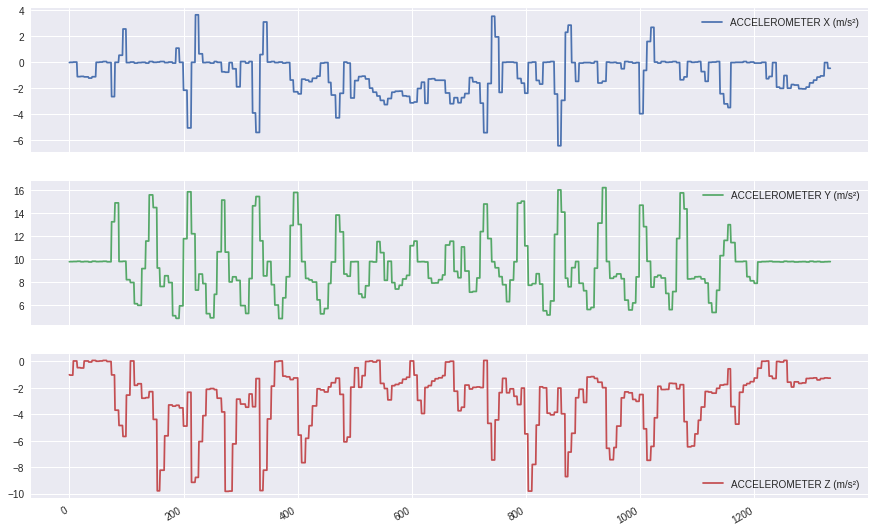

In [ ]:
# Take a look at all sensor outputs
df.iloc[:,0:3].plot(subplots=True,sharex=True,layout=(3,1), figsize=(15,10))
plt.show()

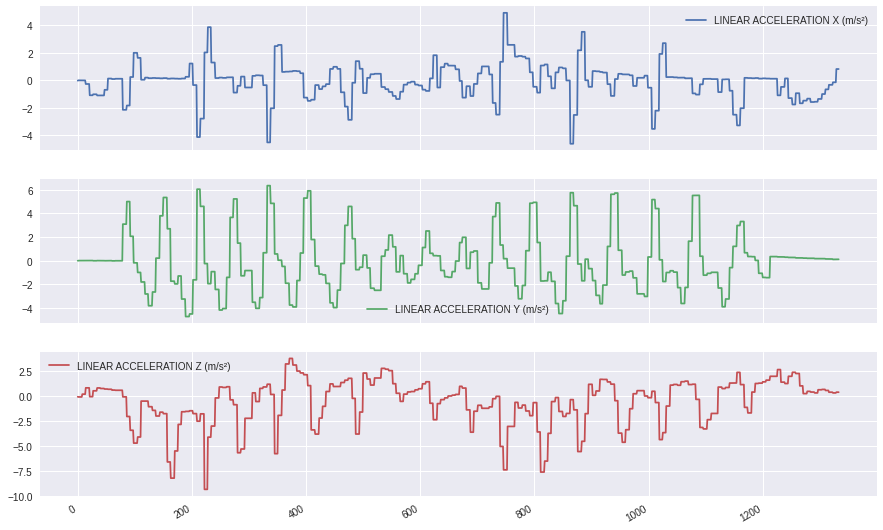

In [ ]:
# Take a look at all sensor outputs
df.iloc[:,6:9].plot(subplots=True,sharex=True,layout=(3,1), figsize=(15,10))
plt.show()

In [ ]:
dt = 0.005 # Sampling at 100Hz

In [ ]:
# Transform body frame accelerations into the inertial (Earth) frame
    # Rotation matrices
def R_x(x):
    # body frame rotation about x axis
    return np.array([[1,      0,       0],
                     [0,cos(-x),-sin(-x)],
                     [0,sin(-x), cos(-x)]])

def R_y(y):
    # body frame rotation about y axis
    return np.array([[cos(-y),0,-sin(-y)],
                    [0,      1,        0],
                    [sin(-y), 0, cos(-y)]])

def R_z(z):
    # body frame rotation about z axis
    return np.array([[cos(-z),-sin(-z),0],
                     [sin(-z), cos(-z),0],
                     [0,      0,       1]])

# Set up arrays to hold acceleration data for transfromation
accel = np.array([df['ACCELEROMETER X (m/s²)'],
                  df['ACCELEROMETER Y (m/s²)'],
                  df['ACCELEROMETER Z (m/s²)']])
grav = np.array([df['GRAVITY X (m/s²)'],
                 df['GRAVITY Y (m/s²)'],
                 df['GRAVITY Z (m/s²)']])
line = np.array([df['LINEAR ACCELERATION X (m/s²)'],
                 df['LINEAR ACCELERATION Y (m/s²)'],
                 df['LINEAR ACCELERATION Z (m/s²)']])

# Set up arrays to hold euler angles for rotation matrices
pitch = df['ORIENTATION X (pitch °)']
roll = df['ORIENTATION Y (roll °)']
yaw = df['ORIENTATION Z (azimuth °)']

# Initilize arrays for new transformed accelerations
earth_accels = np.empty(accel.shape)
earth_gravity = np.empty(accel.shape)
earth_linear = np.empty(accel.shape)

# Perform frame transformations (body frame --> earth frame) 
for i in range(df.shape[0]):
    # accel_earth = (RzRyRx)(accel_body)
    earth_accels[:,i] = R_z(yaw[i]) @ R_y(roll[i]) @ R_x(pitch[i]) @ accel[:,i]
    earth_gravity[:,i] = R_z(yaw[i]) @ R_y(roll[i]) @ R_x(pitch[i]) @ grav[:,i]
    earth_linear[:,i] = R_z(yaw[i]) @ R_y(roll[i]) @ R_x(pitch[i]) @ line[:,i]

# Create new columns in dataframe for earth frame accelerations    
df['EARTH ACCELERATION X'] = earth_accels[0,:]
df['EARTH ACCELERATION Y'] = earth_accels[1,:]
df['EARTH ACCELERATION Z'] = earth_accels[2,:]
df['EARTH GRAVITY X'] = earth_gravity[0,:]
df['EARTH GRAVITY Y'] = earth_gravity[1,:]
df['EARTH GRAVITY Z'] = earth_gravity[2,:]
df['EARTH LINEAR ACCELERATION X'] = earth_linear[0,:]
df['EARTH LINEAR ACCELERATION Y'] = earth_linear[1,:]
df['EARTH LINEAR ACCELERATION Z'] = earth_linear[2,:]


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:191: UserWarning: When passing multiple axes, layout keyword is ignored
  "When passing multiple axes, layout keyword is ignored", UserWarning
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


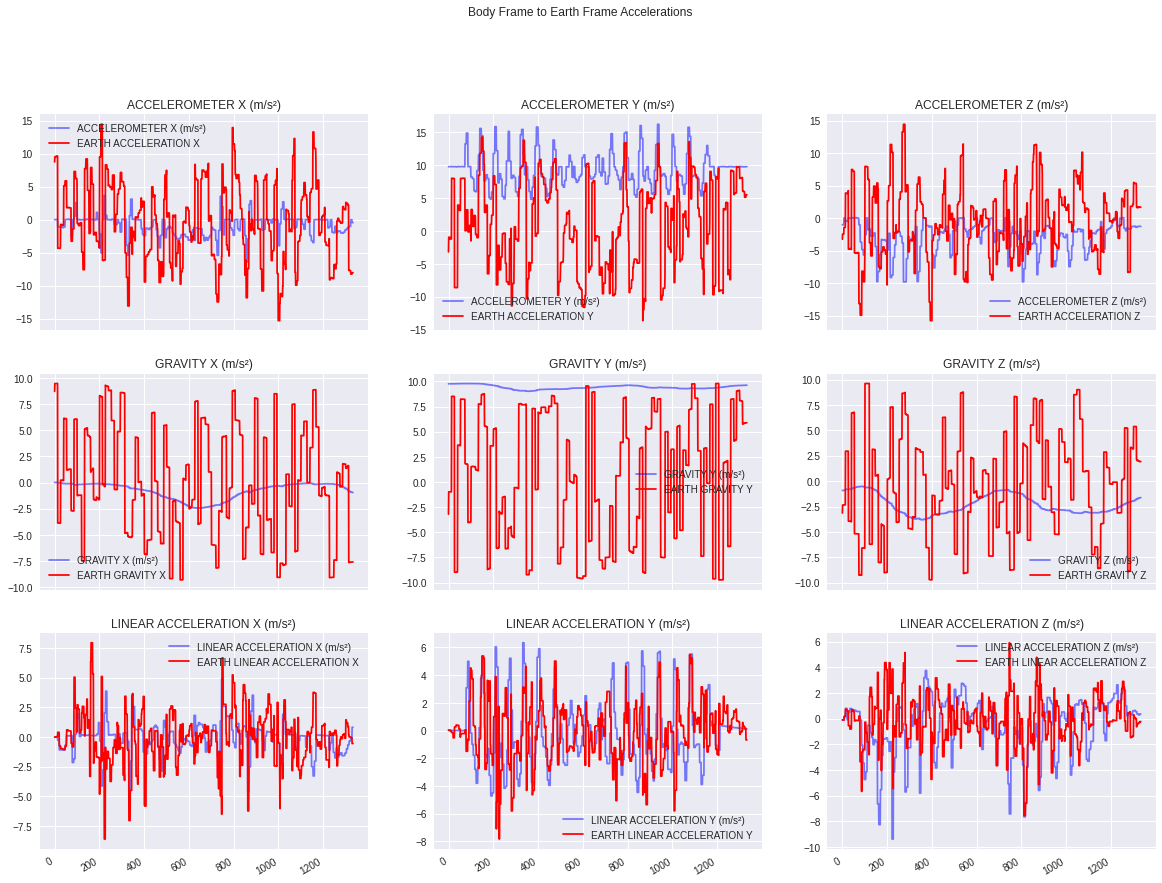

In [ ]:
# Plot new accelerations
cols_earth = ['EARTH ACCELERATION X','EARTH ACCELERATION Y',
              'EARTH ACCELERATION Z','EARTH GRAVITY X','EARTH GRAVITY Y',
              'EARTH GRAVITY Z','EARTH LINEAR ACCELERATION X',
              'EARTH LINEAR ACCELERATION Y','EARTH LINEAR ACCELERATION Z']
cols_body = ['ACCELEROMETER X (m/s²)','ACCELEROMETER Y (m/s²)',
             'ACCELEROMETER Z (m/s²)', 'GRAVITY X (m/s²)', 'GRAVITY Y (m/s²)',
             'GRAVITY Z (m/s²)', 'LINEAR ACCELERATION X (m/s²)',
             'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)',]

bodyplot = df.plot(y=cols_body,subplots=True,sharex=True,layout=(3,3), figsize=(20,15),
                   title=cols_body,style='b',alpha=0.5)

df.plot(y=cols_earth,subplots=True,layout=(3,3),ax=bodyplot,sharex=True, figsize=(20, 15),
        style='r',title='Body Frame to Earth Frame Accelerations')
plt.show()

In [ ]:
# Double integrate accelerations to find positions
x = cumtrapz(cumtrapz(df['EARTH LINEAR ACCELERATION X'],dx=dt),dx=dt)
y = cumtrapz(cumtrapz(df['EARTH LINEAR ACCELERATION Y'],dx=dt),dx=dt)
z = cumtrapz(cumtrapz(df['EARTH LINEAR ACCELERATION Z'],dx=dt),dx=dt)

<Figure size 1440x1080 with 0 Axes>

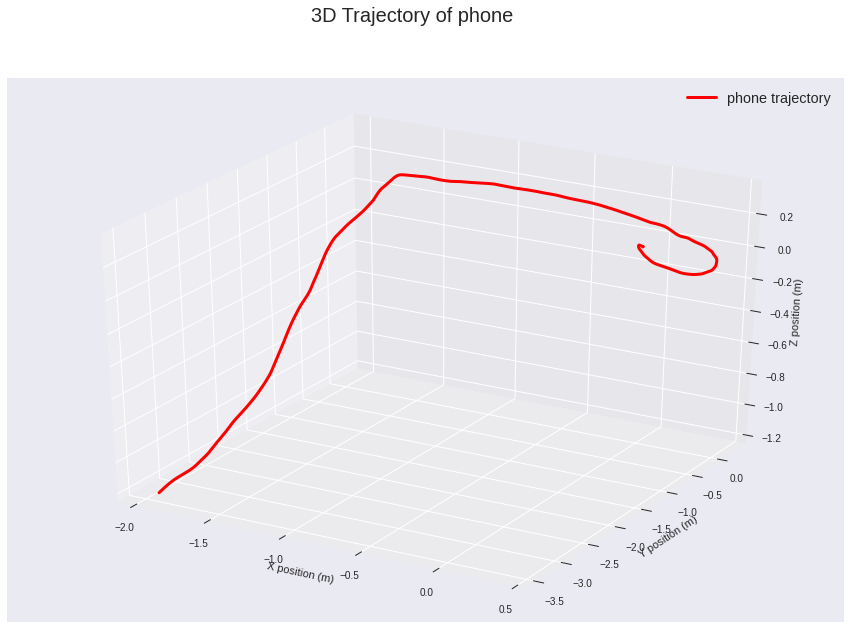

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
# Plot 3D Trajectory
plt.figure(figsize=(20,15))
fig3,ax = plt.subplots()
fig3.suptitle('3D Trajectory of phone',fontsize=20)
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z,c='red',lw=3,label='phone trajectory', )
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
ax.legend(fontsize='x-large')

In [ ]:
# # Notice drift in position

# Try to remove noise via Fourier analysis
    # Discrete Fourier Transform sample frequencies
freq = np.fft.rfftfreq(df['EARTH LINEAR ACCELERATION X'].size,d=dt)
# Compute the Fast Fourier Transform (FFT) of acceleration signals
fft_x = np.fft.rfft(df['EARTH LINEAR ACCELERATION X'])
fft_y = np.fft.rfft(df['EARTH LINEAR ACCELERATION Y'])
fft_z = np.fft.rfft(df['EARTH LINEAR ACCELERATION Z'])

Text(0.5, 0, 'Frequency (Hz)')

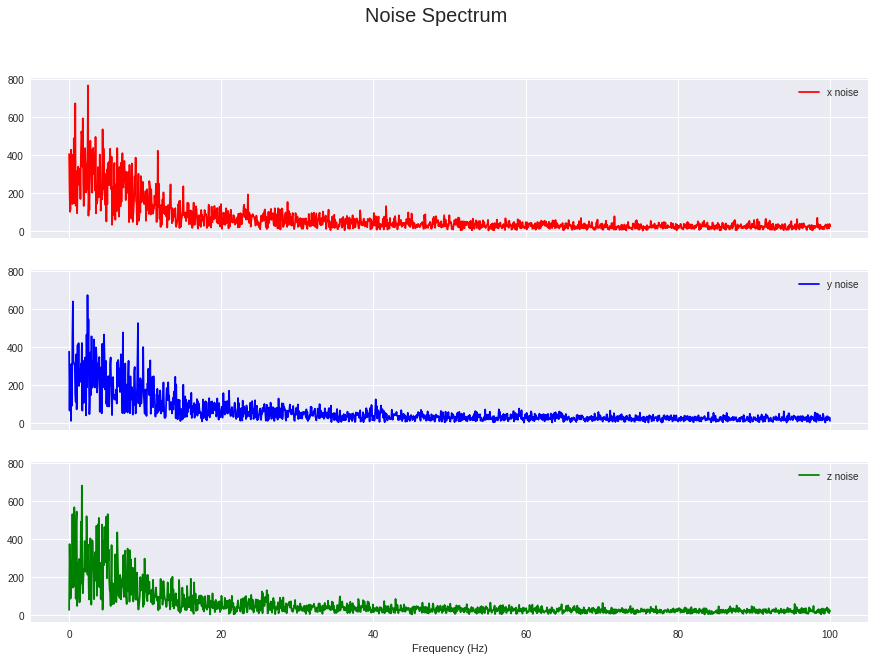

In [ ]:
# Plot Frequency spectrum
fig4,[ax1,ax2,ax3] = plt.subplots(3,1,sharex=True,sharey=True)
fig4.suptitle('Noise Spectrum',fontsize=20)
ax1.plot(freq,abs(fft_x),c='r',label='x noise')
ax1.legend()
ax2.plot(freq,abs(fft_y),c='b',label='y noise')
ax2.legend()
ax3.plot(freq,abs(fft_z),c='g',label='z noise')
ax3.legend()
ax3.set_xlabel('Frequency (Hz)')

In [ ]:
# Attenuate noise in X,Y below 1Hz by 0.2
atten_x_fft = np.where(freq < 5,fft_x * 0.1, fft_x)
atten_y_fft = np.where(freq < 5,fft_y * 0.1, fft_y)
atten_z_fft = np.where((freq > 2) & (freq < 5),fft_z * 0.1, fft_z)

In [ ]:
# Compute inverse of discrete Fourier Transform and save to dataframe
df['x_ifft'] = np.fft.irfft(atten_x_fft,n=df.shape[0])
df['y_ifft'] = np.fft.irfft(atten_y_fft,n=df.shape[0])
df['z_ifft'] = np.fft.irfft(atten_z_fft,n=df.shape[0])

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:191: UserWarning: When passing multiple axes, layout keyword is ignored
  "When passing multiple axes, layout keyword is ignored", UserWarning
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


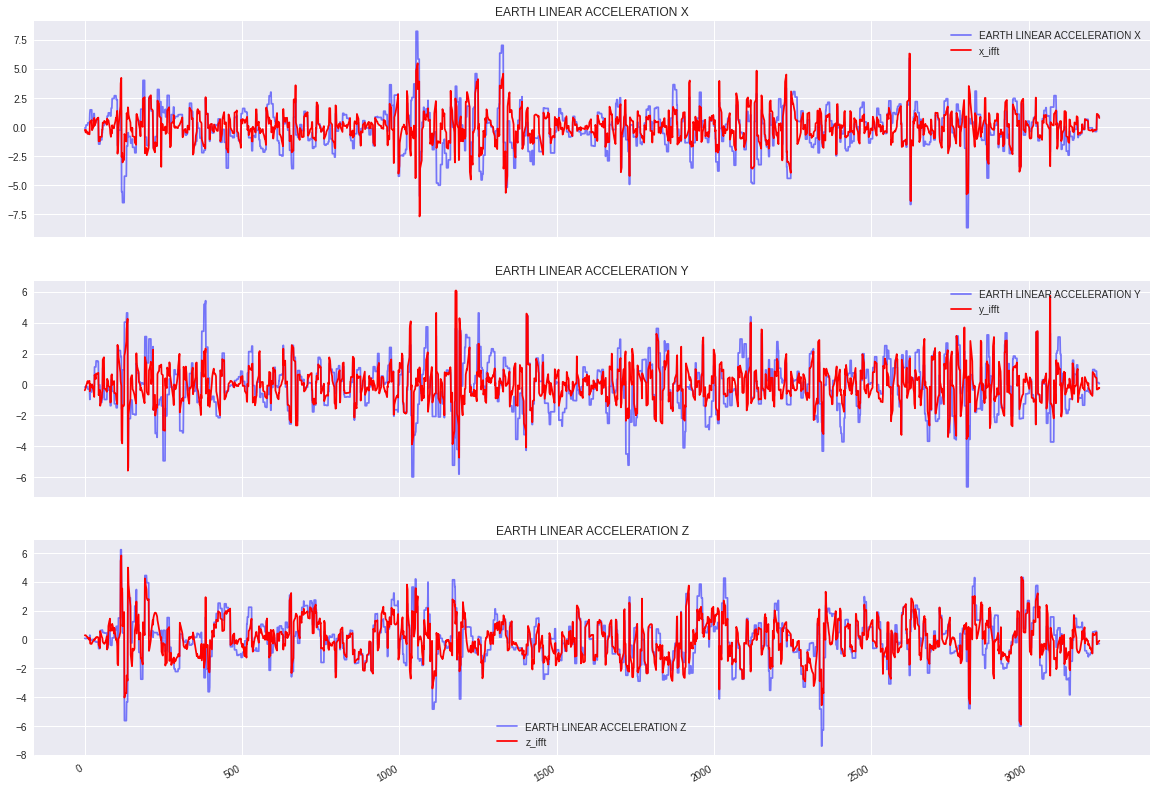

In [ ]:
# Plot new acceleration signals
cols_raw = ['EARTH LINEAR ACCELERATION X','EARTH LINEAR ACCELERATION Y', 'EARTH LINEAR ACCELERATION Z']
cols_new = ['x_ifft','y_ifft','z_ifft']

rawplot = df.plot(y=cols_raw,subplots=True,sharex=True,layout=(3,1),style='b', figsize=(20,15),
                    title=cols_raw,alpha=0.5,legend=False)

df.plot(y=cols_new,subplots=True,layout=(3,1),ax=rawplot,sharex=True,style='r', figsize=(20,15), legend=True)
plt.show()

In [ ]:
# Double integrate accelerations to calculate coordinate positions
fx = cumtrapz(cumtrapz(df['x_ifft'],dx=dt),dx=dt)
fy = cumtrapz(cumtrapz(df['y_ifft'],dx=dt),dx=dt)
fz = cumtrapz(cumtrapz(df['z_ifft'],dx=dt),dx=dt)

<Figure size 1440x1080 with 0 Axes>

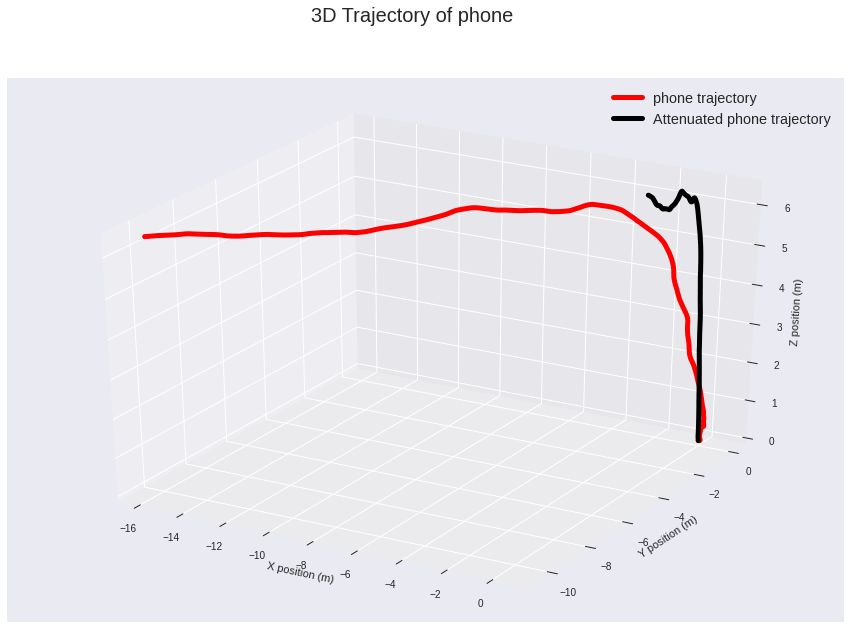

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
# Plot 3D Trajectory
plt.figure(figsize=(20,15))
fig3,ax = plt.subplots()
fig3.suptitle('3D Trajectory of phone',fontsize=20)
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z,c='red',lw=5,label='phone trajectory')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
ax.legend(fontsize='x-large')
ax.plot3D(fx,fy,fz,'k',lw=5,label='Attenuated phone trajectory')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
ax.legend(fontsize='x-large')


In [ ]:
# Kalman filter 
# State Transition Matrix
A = np.array([[1.0, dt],
              [0.0, 1.0]])

# Control Matrix
B = np.array([[0.5*dt**2],
              [dt]])

# Control vector
u = np.array([[0.0]])

# Process Noise Matrix
max_position_change = 0.5 * 0.5 * dt**2  # assume max accel = 0.5
max_velocity_change = 0.5 * dt          # assume max accel = 0.5
Q = np.array([[max_position_change, 0],
              [0, max_velocity_change]])

# Measurement Matrix
H = np.array([[1, 0]])  # Only able to measure position

# Measurement noise covariance matrix
sbarometer = 1.0  # accurate to +- 1m
R = np.array([[sbarometer**2]])

# Measurement
z_m = np.array([[0.0]])

# Initial System State Matrix (pos_z = 0, vel_z = 0 at t = 0)
X = np.array([[0.0],
              [0.0]])

In [ ]:
# Initial Process Covariance Matrix
spos = 0.0  # No uncertainty in initial state
svel = 0.0
P = np.array([[spos**2, svel*spos],
              [spos*svel, svel**2]])
# 2x2 Identity Matrix
I = np.eye(2)

X_pos = []
X_vel = []
P_pos = []
P_vel = []
K_pos = []
K_vel = []

In [ ]:
# --- 1d Kalman Filter ---
for i in range(df.shape[0]):

    # Pull in z acceleration control input
    u[0][0] = df['z_ifft'][i]

    # Predict the next state
    X = A @ X + B @ u
    P = A @ P @ A.T + Q

    # Altitude measurement every 15 accelerometer updates (dt=0.01s vs dt_barometer = 0.015s)
    if i % 15 == 0:

        # Pull in altitude measurement
        z_m[0][0] = df['GYROSCOPE Z (rad/s)'][i]

        # Update the next state
        K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)  # Kalman Gain
        X = X + K @ (z_m - H @ X)                     # Updated State
        P = (I - K @ H) @ P                           # Updated Covariance

    # --- Store system states variables, Kalman Gain, and covariances ---
    X_pos.append(X[0][0])
    X_vel.append(X[1][0])
    P_pos.append(P[0][0])
    P_vel.append(P[1][1])
    K_pos.append(K[0][0])
    K_vel.append(K[1][0])

<Figure size 1440x1080 with 0 Axes>

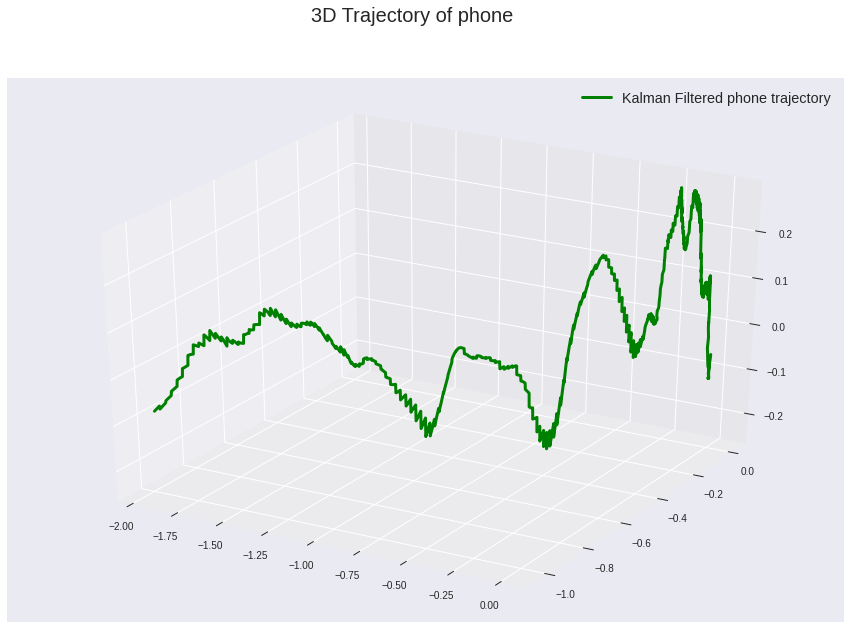

In [ ]:
# # Kalman Filter Plot
# Plot new trajectory on 3D plot
plt.rcParams['figure.figsize'] = [15, 10]
# Plot 3D Trajectory
plt.figure(figsize=(20,15))
fig3,ax = plt.subplots()
fig3.suptitle('3D Trajectory of phone',fontsize=20)
ax = plt.axes(projection='3d')
ax.plot3D(fx,fy,X_pos[:-2],'g',lw=3,label='Kalman Filtered phone trajectory')
ax.legend(fontsize='x-large')